# Test hypotézy

Cílem tohoto zadaní ověřit 2 teorie.

# Hypotéza 1:
*"Na silnicích první třídy se při nehodách umíralo se stejnou pravděpodobností jako na silnicích třetí třídy"*


Prvním krokem nahrajeme potřebné knihovny pro zpracování dat `numpy`, `pandas`, `matplotlib`, a takže knihovnu pro statistickou analyzu `scipy.stats`.

In [1]:
import numpy as np, pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

Načteme data, vyfiltrujeme je dle druhu pozemní komunikace (silnice 1. a 3. třídy) a přídáme sloupec "Úmrtnost" - kde bude jenom zaznamenovat, došlo li během nehody k smrti (True - došlo, False - nedošlo). 

In [2]:
df = pd.read_pickle("accidents.pkl.gz")
df_h1 = df[(df['p36'] == 1) | (df['p36'] == 3)]
df_h1 = df_h1[['p36', 'p13a']]
df_h1['Úmrtnost'] = (df['p13a'] > 0)
df_h1[['p36', 'Úmrtnost']]

,p36,Úmrtnost
7594,1,False
10530,1,False
10532,1,False
13362,1,False
21478,1,False
...,...,...
572914,3,False
572922,3,False
572931,3,False
572932,3,False


Před tím jak budeme ověřovat hypotézu potřebujeme vytvořit kontingenční tabulku pro všechny čtyři kombinace vstupů. 

In [3]:
ct = pd.crosstab(df_h1['p36'], df_h1['Úmrtnost'])
ct

Úmrtnost,False,True
p36,,
1,78618,911
3,73352,448


Pro ověřovaní hypotézy využime z $\chi^2$ test.

In [4]:
scipy.stats.chi2_contingency(ct)

(125.72070150000258,
 3.5395243450138555e-29,
 1,
 array([[78824.11109444,   704.88890556],
        [73145.88890556,   654.11109444]]))

Hodnota $3.54\cdot10^{-29}$ je mnohem menší než $0.05$. Proto __zamítneme nulovou hypotézu__ a zároveň expected hodnoty ukazují, že na silnici první třídy se při nehodách umíralo s větší pravděpodobností než na silnicích třetí třídy.

# Hypotéza 2:
*"Při nehodách vozidel značky Škoda je škoda na vozidle nižší než při nehodách vozidel Audi"*

Vyfiltrujeme data dle výrobní značky vozidla a hahrajeme je příslušnými auty. Zobrazime pouze druh auta a velikost škody.

In [5]:
df_h2 = df.copy()
df_h2 = df_h2[(df['p45a'] == 2) | (df['p45a'] == 39)]
df_h2['p45a'] = df_h2['p45a'].apply(lambda x: 'Audi' if x == 2 else 'Škoda')
df_h2[['p45a', 'p53']]

,p45a,p53
0,Audi,4000
6,Škoda,200
9,Škoda,300
11,Škoda,50
16,Škoda,1200
...,...,...
572911,Škoda,10
572916,Škoda,130
572921,Škoda,100
572923,Škoda,0


Vizuálně zkontrolujeme jestli data jsou normální. Nemůžeme využit Shapiro-Wilkův test protože máme víc než 5000 prvků.

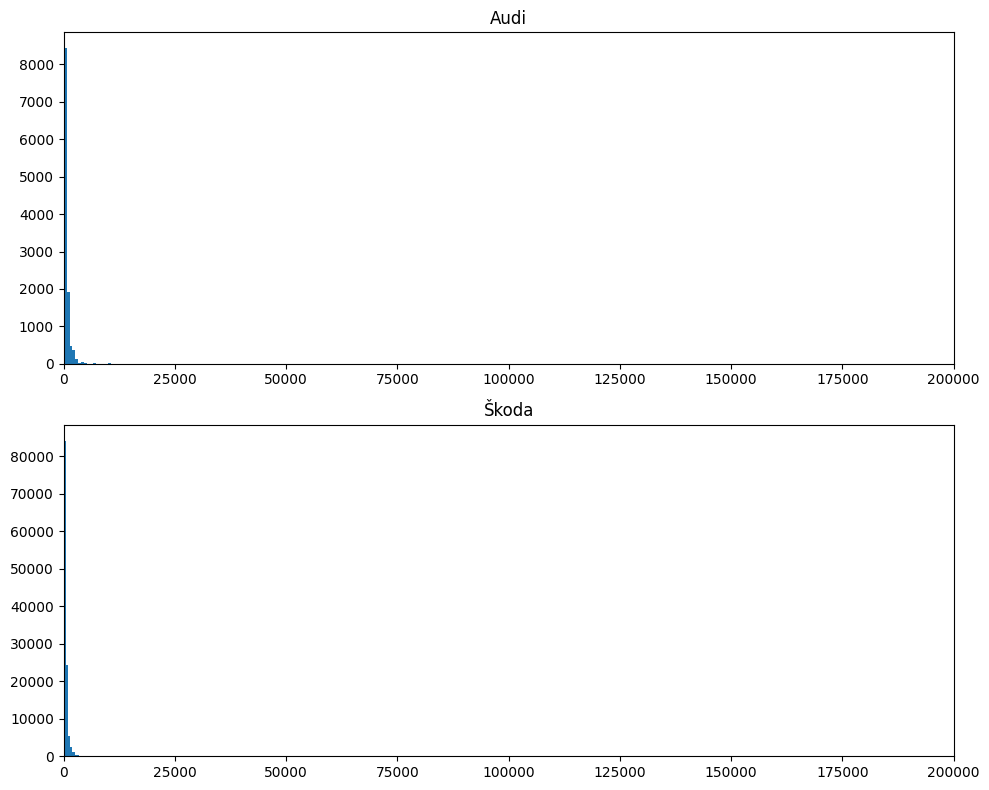

In [6]:
plt.figure(figsize=(10 , 8))
for figid, (p45a, d) in enumerate(df_h2.groupby("p45a")):
    plt.subplot(211 + figid)
    plt.hist(d["p53"], label=p45a, bins=30)
    plt.title(p45a)
    plt.xlim(0, df['p53'].max())
plt.tight_layout()

Dle grafů můžeme vidět, že se nejedná o normální data. Tím pádem máme využit Mann-Whitney U-Test, Wilcoxon signed-rank test nemůžeme využit protože nemáme žádnou asociaci mezi dvěma proměnnými.

In [7]:
df_h2 = df_h2.set_index(['p45a'])
a = df_h2.loc['Audi', 'p53']
b = df_h2.loc['Škoda', 'p53']
print(a.median(), b.median())
scipy.stats.mannwhitneyu(a, b)

300.0 200.0


MannwhitneyuResult(statistic=789001736.0, pvalue=4.921643600739696e-188)

Hodnota p-value je o mnohem menši než 0.05 (zamítáme nulovou hypotézu), což znamená že škoda na vozidlech Audi je o mnohem vyšší než na vozidlech Škoda. Hypotéza má pravdu.